# Project 10 - Energy Consumption Prediction 
- ### using XGBoost
- ### Train/Test R2 : **75.11%**, **51.69%**

- Course Name :         Applied Machine Learning
- Course instructor:    Sohail Tehranipour
- Student Name :        Afshin Masoudi Ashtiani
- Project 10 :           Energy Consumption Prediction
- Date :                September 2024
- Files :               2/2

<img src="https://www.heatherhomes.in/wp-content/uploads/2017/11/Reduce-Energy-Consumption-at-Home.jpg">

## Step 1 : Install required libraries

In [140]:
%pip install numpy pandas
%pip install matplotlib seaborn plotly
%pip install xgboost scikit-learn keras

Note: you may need to restart the kernel to use updated packages.




## Step 2 : Import required libraries

In [141]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Mount google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Warnings
import warnings
warnings.filterwarnings('ignore')

## Step 3 : Load and prepare the dataset (Energy Consumption)

In [142]:
data_dir = r'f:/Python_Projects/AppliedMechineLearningWithPython/Project_10_Energy_Consumption_Prediction/datasets'
# data_dir = '/content/drive/My Drive/Applied Machine Learning/Project 10 : Energy Consumption Prediction/datasets'
# data_dir = '/kaggle/input/hourly-energy-consumption'

data_path = os.path.join(data_dir, 'PJME_hourly.csv')
energy_df = pd.read_csv(data_path)

energy_df.info()
energy_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


Datetime  PJME_MW
2683    2002-09-11 21:00:00  35093.0
1661    2002-10-23 07:00:00  29025.0
109482  2014-07-05 19:00:00  34257.0
54424   2008-10-15 06:00:00  25246.0
127209  2016-06-26 10:00:00  29141.0

- Set 'Datetime' to index

In [143]:
energy_df.set_index(keys='Datetime', inplace=True)
energy_df.sample(5)

PJME_MW
Datetime                    
2002-11-25 10:00:00  33184.0
2008-11-10 04:00:00  23263.0
2004-01-08 20:00:00  40944.0
2007-06-16 14:00:00  34322.0
2011-02-15 21:00:00  38337.0

- Convert 'Datetime' type into datetime

In [144]:
energy_df.index = pd.to_datetime(energy_df.index)
energy_df = energy_df.sort_index()
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


## Step 4 : Data Cleaning

- ### Handle **missing values**

In [145]:
energy_df.isnull().sum()

PJME_MW    0
dtype: int64

In [146]:
# Handle Missing Values
print(f'> Shape of energy dataset before handling missing values: {energy_df.shape}')
energy_df.dropna(inplace=True)
print(f'> Shape of energy dataset after  handling missing values: {energy_df.shape}')

> Shape of energy dataset before handling missing values: (145366, 1)
> Shape of energy dataset after  handling missing values: (145366, 1)


- ### Handle **outliers**

In [147]:
energy_df.describe()

PJME_MW
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000

- Visualize the outliers

In [148]:
def plot_bell_curve(data: pd.DataFrame, feature_name: str):
    # Calculate the mean and standard deviation
    mean = data[feature_name].mean()
    std_dev = data[feature_name].std()

    # Create the histogram
    fig = px.histogram(data, x=feature_name, nbins=500, 
                       title="Bell Curve", 
                       histnorm='probability density')  # Normalize for probability density
    fig.update_traces(marker=dict(color="blue", opacity=0.5))

    # Create the bell curve using a range of x values
    x_values = np.linspace(data[feature_name].min(), data[feature_name].max(), 1000)
    y_values = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - mean) / std_dev) ** 2)

    # Add bell curve to the existing figure
    fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='lines', 
                             name='Bell Curve', line=dict(color='red', width=2)))

    # Update layout titles
    fig.update_layout(
        title='Hourly Energy Consumption with Bell Curve',
        xaxis_title=feature_name,
        yaxis_title="Density",
        template='plotly',
        showlegend=True
    )

    fig.show()

def plot_box(data: pd.DataFrame, feature_name: str):
    """Plots a box plot for the specified feature in the given DataFrame."""
    
    # Create a box plot
    fig = px.box(data, x=feature_name, points="all")  # Show all points to visualize outliers
    
    # Add titles and labels
    fig.update_layout(
        title=f'Box Plot of {feature_name}',
        xaxis_title=feature_name,
        yaxis_title='Value',
        template='plotly'
    )

    # Show the figure
    fig.show()

plot_bell_curve(energy_df, 'PJME_MW')
plot_box(energy_df, 'PJME_MW')

- Eliminate PJME under 19000 MW

In [149]:
print(f'> Shape of energy dataset before handling PJME_MW limits is {energy_df.shape}.')
energy_df = energy_df.query('PJME_MW > 19_000')
print(f'> Shape of energy dataset after handling PJME_MW limits is {energy_df.shape}.')

> Shape of energy dataset before handling PJME_MW limits is (145366, 1).
> Shape of energy dataset after handling PJME_MW limits is (145351, 1).


## Step 5 : Exploratory Data Analysis (EDA)

In [150]:
energy_df.describe()

PJME_MW
count  145351.000000
mean    32081.810473
std      6462.435417
min     19085.000000
25%     27575.000000
50%     31421.000000
75%     35650.000000
max     62009.000000

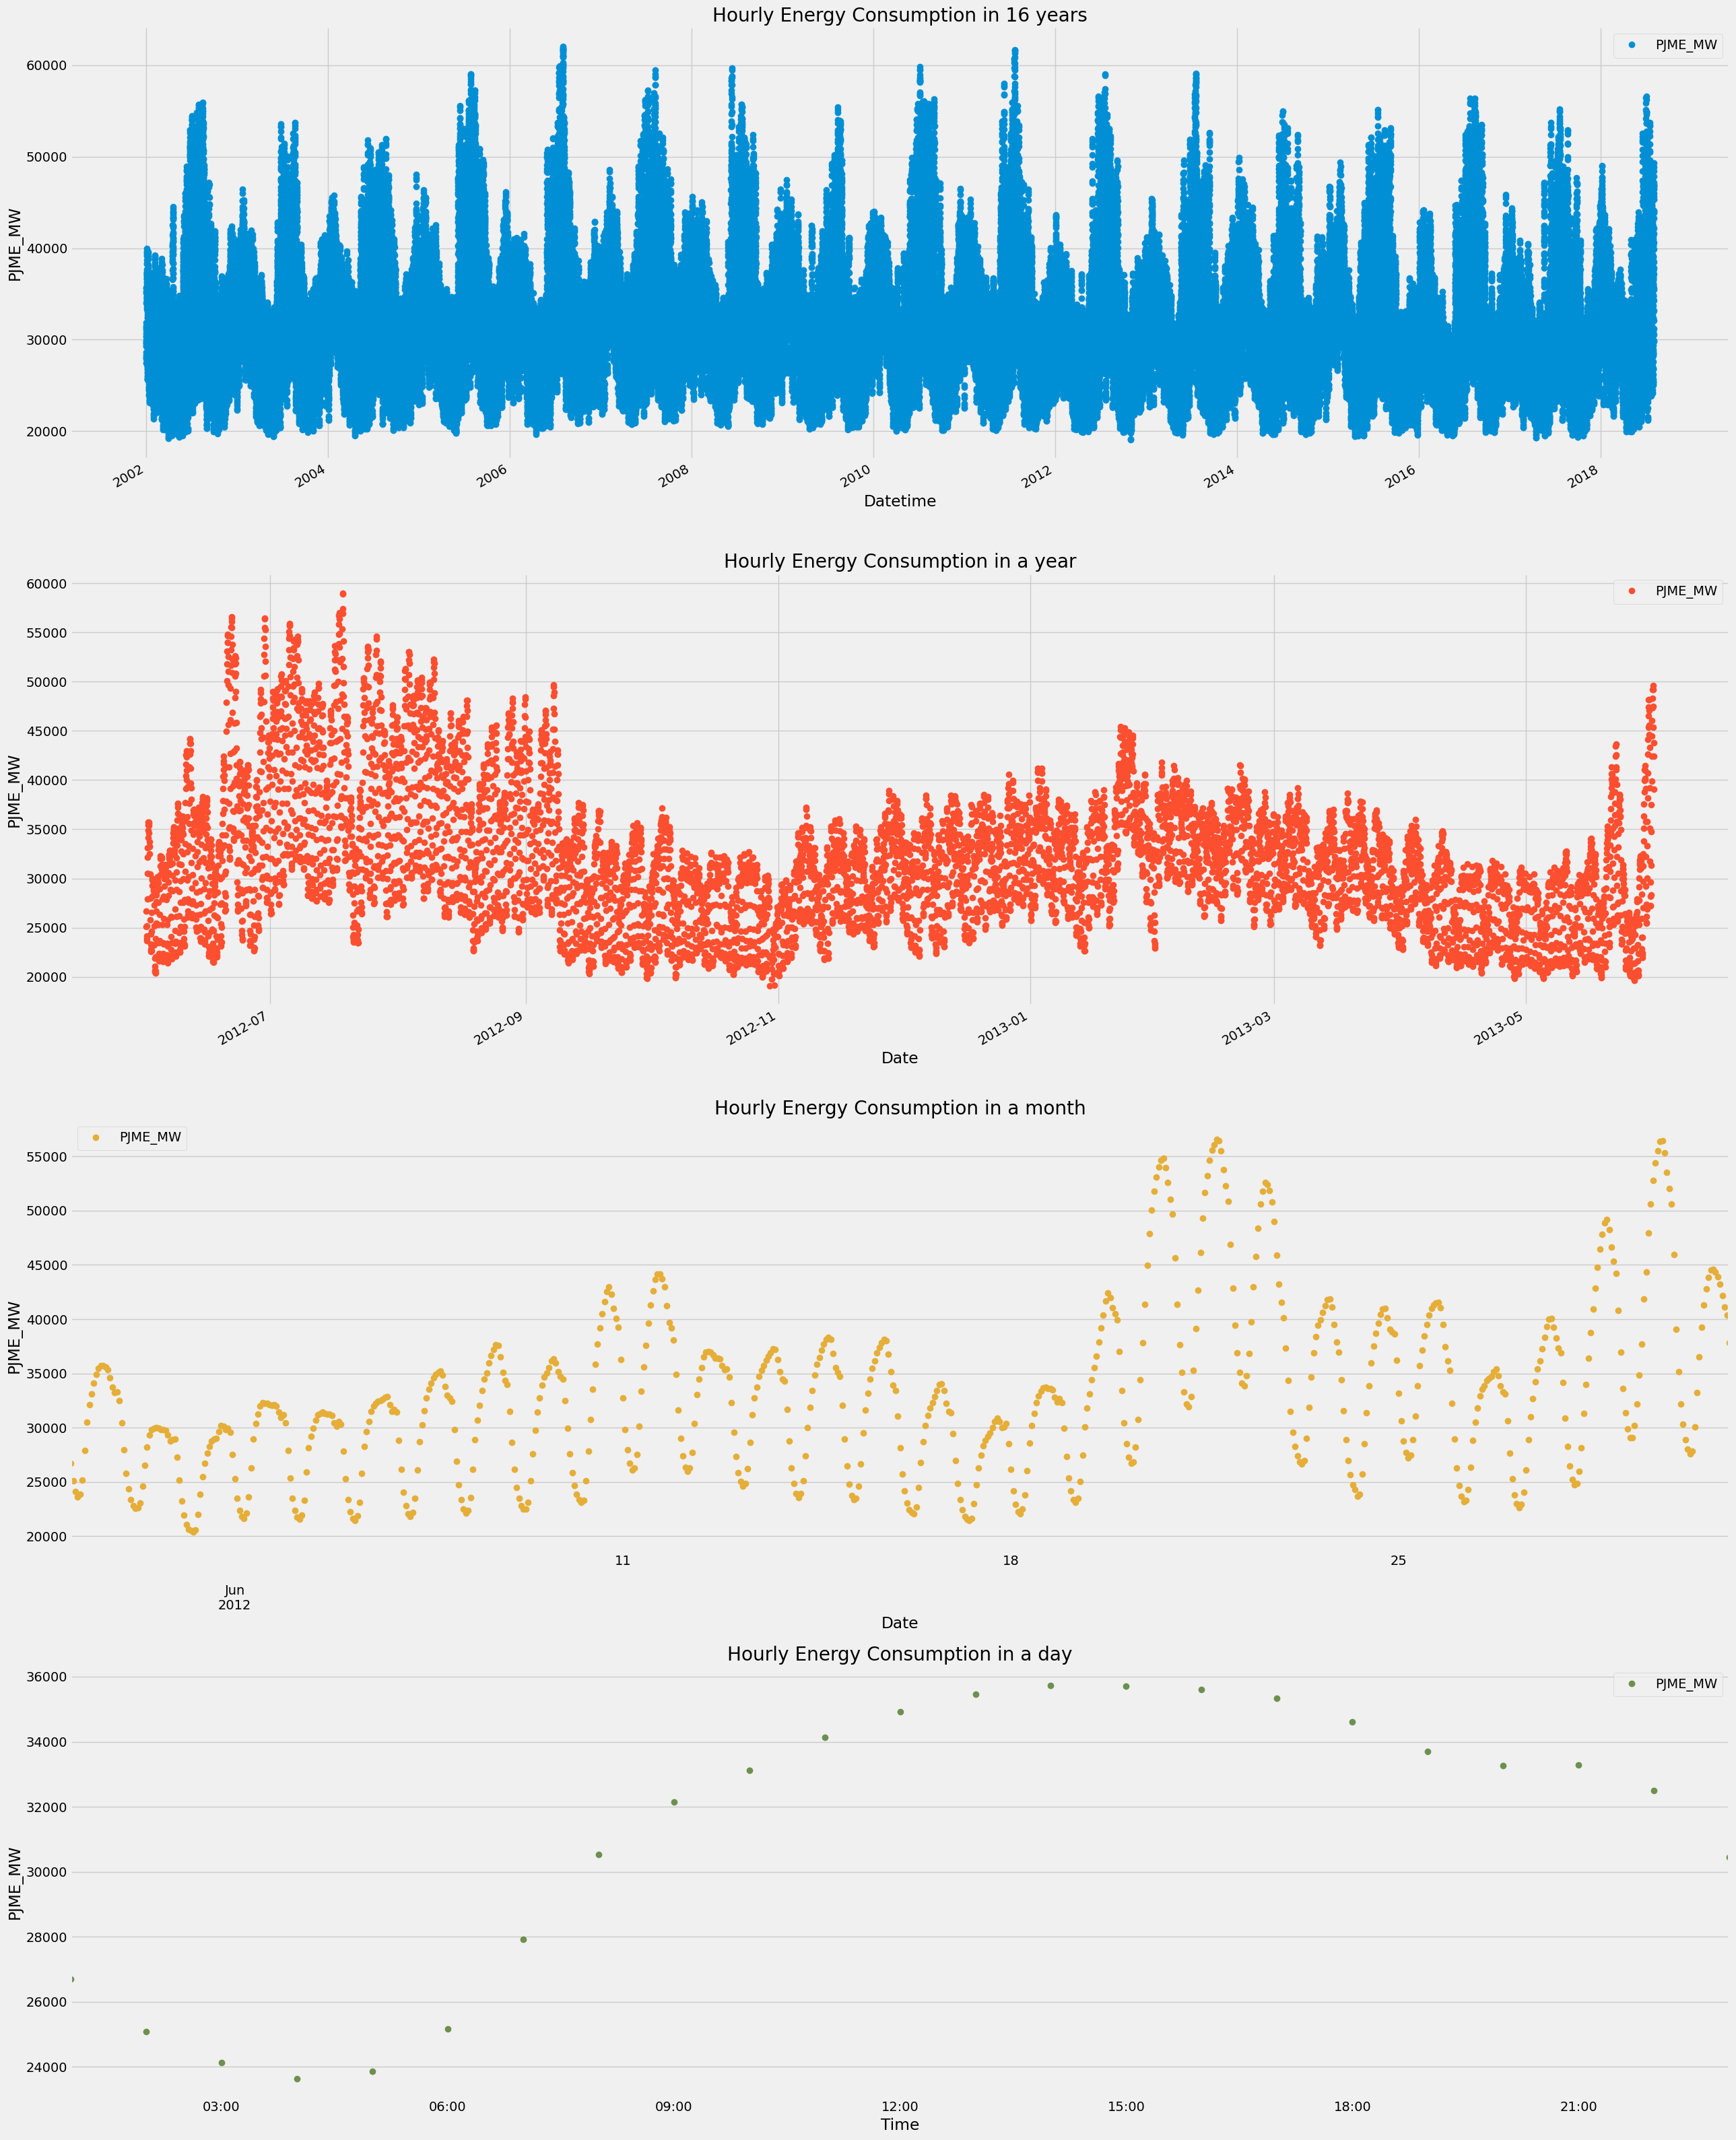

In [151]:
def calculate_dates(date_str: str):
    """Generate date ranges based on the input date."""
    date_parts = list(map(int, date_str.split('-')))
    start_date = pd.Timestamp(year=date_parts[2], month=date_parts[0], day=date_parts[1])
    return {
        'one_year': start_date + pd.DateOffset(years=1),
        'one_month': start_date + pd.DateOffset(months=1),
        'one_day': start_date + pd.DateOffset(days=1),
    }

def display_hourly_energy_consumption(data: pd.DataFrame, date: str = '06-01-2012'):
    years = (data.index[-1] - data.index[0]).days // 365

    date_ranges = calculate_dates(date)

    fig, axs = plt.subplots(4, 1, figsize=(26, 4 * 8))  # Adjusted figsize for clarity

    # Main Data Plot
    data.plot(y='PJME_MW', style='o', ax=axs[0], color=color_pal[0])
    axs[0].set_title(f'Hourly Energy Consumption in {years} years')
    axs[0].set_ylabel('PJME_MW')

    # Iterating over each time frame to create plots
    timeframes = [('Year', date_ranges['one_year'], color_pal[1]),
                  ('Month', date_ranges['one_month'], color_pal[2]),
                  ('Day', date_ranges['one_day'], color_pal[3])]
    
    for ax, (label, end_date, color) in zip(axs[1:], timeframes):
        time_frame_data = data[(data.index > date) & (data.index < end_date)]
        time_frame_data.plot(y='PJME_MW', style='o', ax=ax, color=color)
        ax.set_title(f'Hourly Energy Consumption in a {label.lower()}')
        ax.set_ylabel('PJME_MW')
        ax.set_xlabel('Date' if label.lower() != 'day' else 'Time')
    
    plt.tight_layout()  # Adjusts subplot params to give specified padding
    plt.show()
    
display_hourly_energy_consumption(energy_df, '06-01-2012')

## Step 6 : Split the dataset into train and test sets

In [152]:
def split_train_test_data(data: pd.DataFrame, split_date: datetime = '01-01-2015') -> tuple:
    """Split the dataset into training and testing sets based on the specified test rate."""
    train = data.loc[energy_df.index < split_date]
    test = data.loc[energy_df.index >= split_date]

    y_train = train.index.tolist()
    y_test = test.index.tolist()

    X_train = train.iloc[:, 0]
    X_test = test.iloc[:, 0]

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test), train, test

split_date = '01-01-2015'
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, train, test= split_train_test_data(energy_df, split_date)

print("> Dataset  Samples  :", energy_df.shape)
print("> Training Samples  :", train.shape)
print("> Training Features :", X_train.shape)
print("> Training Targets  :", y_train.shape)
print("> Testing  Samples  :", test.shape)
print("> Testing  Features :", X_test.shape)
print("> Testing  Targets  :", y_test.shape)

> Dataset  Samples  : (145351, 1)
> Training Samples  : (113911, 1)
> Training Features : (113911,)
> Training Targets  : (113911,)
> Testing  Samples  : (31440, 1)
> Testing  Features : (31440,)
> Testing  Targets  : (31440,)


- Visualize the Train/Test sets

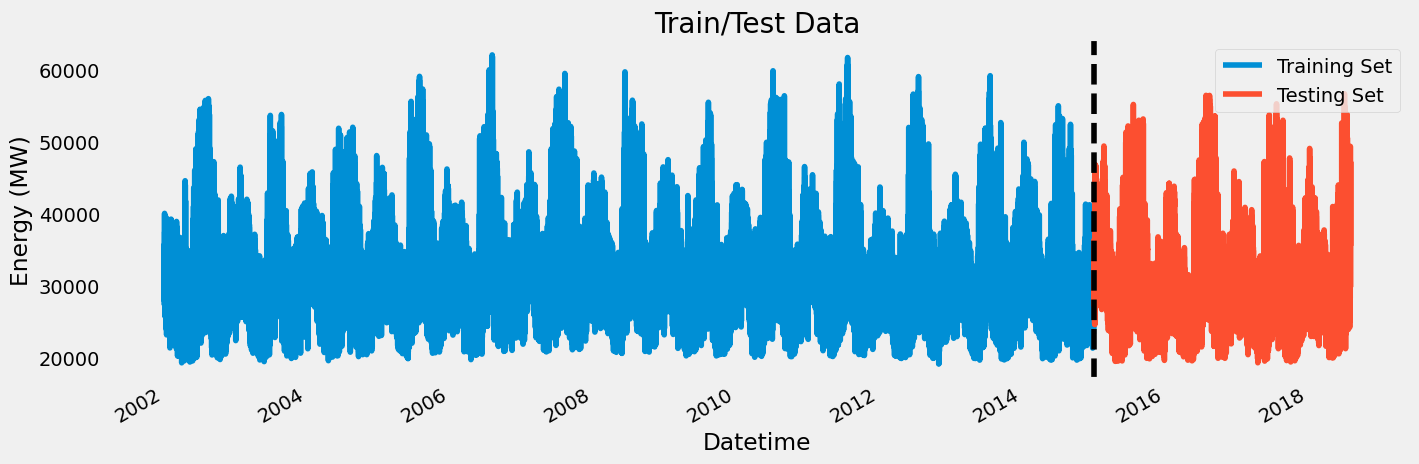

In [153]:
def plot_train_test_data(train, test):
    fig, ax = plt.subplots(figsize=(15, 5))
    train.plot(label='Training Set', color=color_pal[0], ax=ax)
    test.plot(label='Testing Set', color=color_pal[1], ax=ax)
    ax.axvline(test.index[0], color='black', ls='--')
    ax.set_title('Train/Test Data')
    ax.set_ylabel('Energy (MW)')
    ax.set_xlabel('Datetime')
    ax.legend(['Training Set', 'Testing Set'])
    plt.grid()
    plt.show()

plot_train_test_data(train, test)

## Step 6 : TimeSeries Cross Validation

In [154]:
from sklearn.model_selection import TimeSeriesSplit

n_split = 5
gap = 24 # for one day
test_size = 24 * 365 * 1 # for one year

tss = TimeSeriesSplit(n_splits=n_split, test_size=test_size, gap=gap)

- Visualize the cross validation

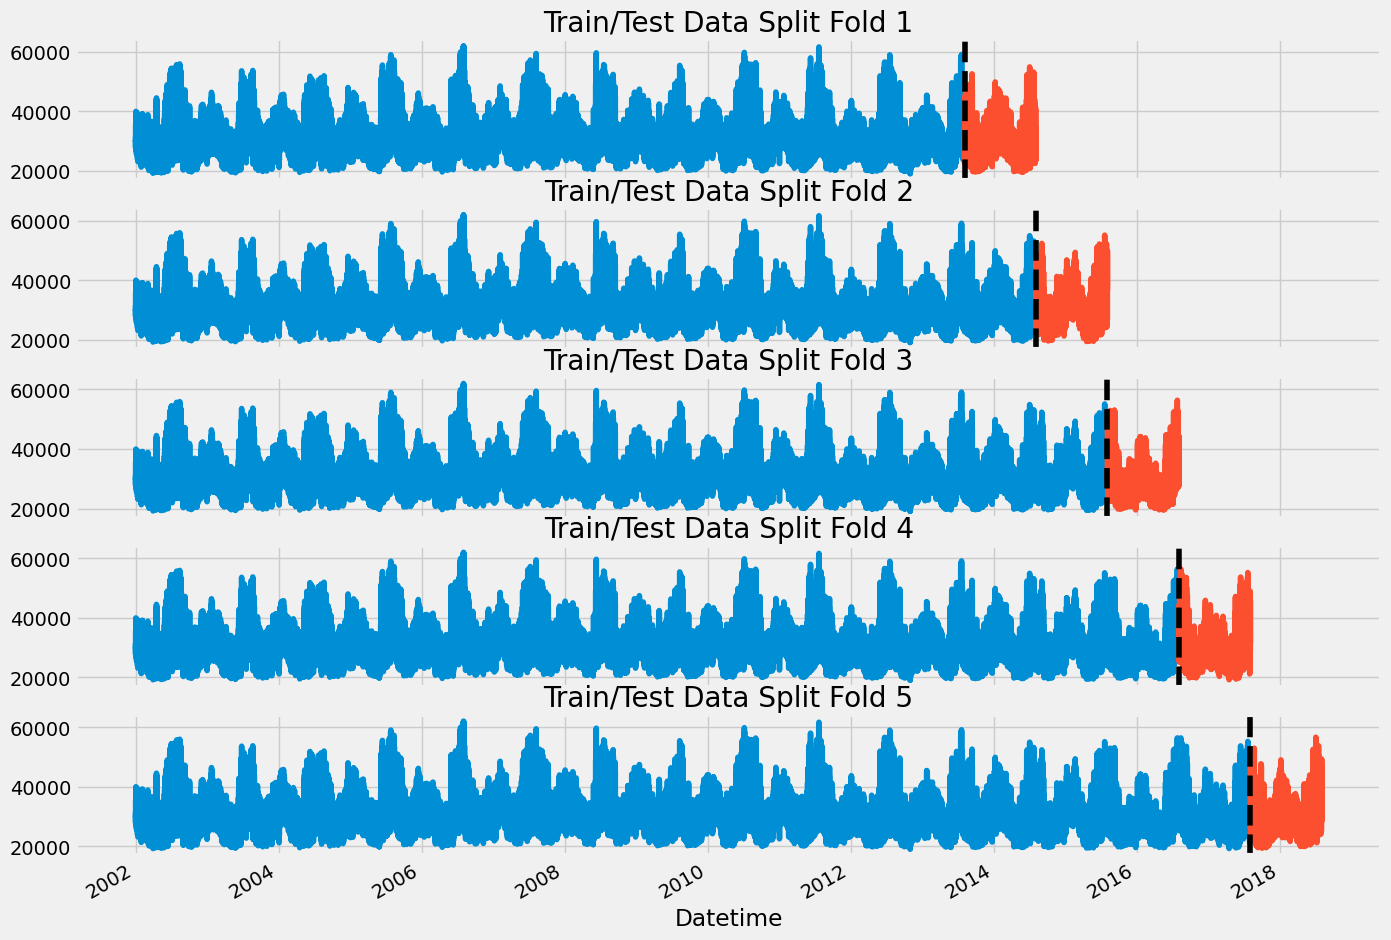

In [155]:
fig, axs = plt.subplots(n_split, 1, figsize=(3 * n_split, 12), sharex=True)
fold = 0
for train_idx, validation_idx in tss.split(energy_df):
    train = energy_df.iloc[train_idx]
    test = energy_df.iloc[validation_idx]
    train['PJME_MW'].plot(ax=axs[fold], label='Training Set', color=color_pal[0], title=f'Train/Test Data Split Fold {fold + 1}')
    test['PJME_MW'].plot(ax=axs[fold], label='Testing Set', color=color_pal[1])
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Step 7 : Create features and lag features

In [156]:
def create_features(data: pd.DataFrame) -> pd.DataFrame:
    data['Hour'] = data.index.hour
    data['Day'] = data.index.day
    data['Month'] = data.index.month
    data['Quarter'] = data.index.quarter
    data['Year'] = data.index.year
    data['DayOfWeek'] = data.index.dayofweek
    data['DayOfYear'] = data.index.dayofyear
    data['WeekOfYear'] = data.index.isocalendar().week
        
    return data

df = create_features(energy_df)
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145351 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PJME_MW     145351 non-null  float64
 1   Hour        145351 non-null  int32  
 2   Day         145351 non-null  int32  
 3   Month       145351 non-null  int32  
 4   Quarter     145351 non-null  int32  
 5   Year        145351 non-null  int32  
 6   DayOfWeek   145351 non-null  int32  
 7   DayOfYear   145351 non-null  int32  
 8   WeekOfYear  145351 non-null  UInt32 
dtypes: UInt32(1), float64(1), int32(7)
memory usage: 6.8 MB


PJME_MW  Hour  Day  Month  Quarter  Year  DayOfWeek  \
Datetime                                                                   
2004-09-20 04:00:00  20733.0     4   20      9        3  2004          0   
2009-02-16 06:00:00  30645.0     6   16      2        1  2009          0   
2005-02-09 20:00:00  35927.0    20    9      2        1  2005          2   
2006-06-18 23:00:00  41245.0    23   18      6        2  2006          6   
2018-07-11 00:00:00  37750.0     0   11      7        3  2018          2   

                     DayOfYear  WeekOfYear  
Datetime                                    
2004-09-20 04:00:00        264          39  
2009-02-16 06:00:00         47           8  
2005-02-09 20:00:00         40           6  
2006-06-18 23:00:00        169          24  
2018-07-11 00:00:00        192          28

In [157]:
def create_lags(data: pd.DataFrame) -> pd.DataFrame:
    target_map = data['PJME_MW'].to_dict()
    data['Lag1'] = (data.index - pd.Timedelta('364 days')).map(target_map)
    data['Lag2'] = (data.index - pd.Timedelta('728 days')).map(target_map)
    data['Lag3'] = (data.index - pd.Timedelta('1092 days')).map(target_map)
    return data

df = create_lags(df)
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145351 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PJME_MW     145351 non-null  float64
 1   Hour        145351 non-null  int32  
 2   Day         145351 non-null  int32  
 3   Month       145351 non-null  int32  
 4   Quarter     145351 non-null  int32  
 5   Year        145351 non-null  int32  
 6   DayOfWeek   145351 non-null  int32  
 7   DayOfYear   145351 non-null  int32  
 8   WeekOfYear  145351 non-null  UInt32 
 9   Lag1        136593 non-null  float64
 10  Lag2        127851 non-null  float64
 11  Lag3        119111 non-null  float64
dtypes: UInt32(1), float64(4), int32(7)
memory usage: 10.1 MB


PJME_MW  Hour  Day  Month  Quarter  Year  DayOfWeek  \
Datetime                                                                   
2014-09-20 00:00:00  24430.0     0   20      9        3  2014          5   
2016-01-09 02:00:00  25601.0     2    9      1        1  2016          5   
2016-07-19 15:00:00  46014.0    15   19      7        3  2016          1   
2007-05-01 21:00:00  33131.0    21    1      5        2  2007          1   
2010-11-21 10:00:00  28058.0    10   21     11        4  2010          6   

                     DayOfYear  WeekOfYear     Lag1     Lag2     Lag3  
Datetime                                                               
2014-09-20 00:00:00        263          38  25814.0  25894.0  29528.0  
2016-01-09 02:00:00          9           1  33730.0  28251.0  25056.0  
2016-07-19 15:00:00        201          29  48070.0  46450.0  49501.0  
2007-05-01 21:00:00        121          18  32361.0  32303.0  31365.0  
2010-11-21 10:00:00        325          46  27693.0  33196.0  30461.0

## Step 8 : Visualize our Features/Target Relationship

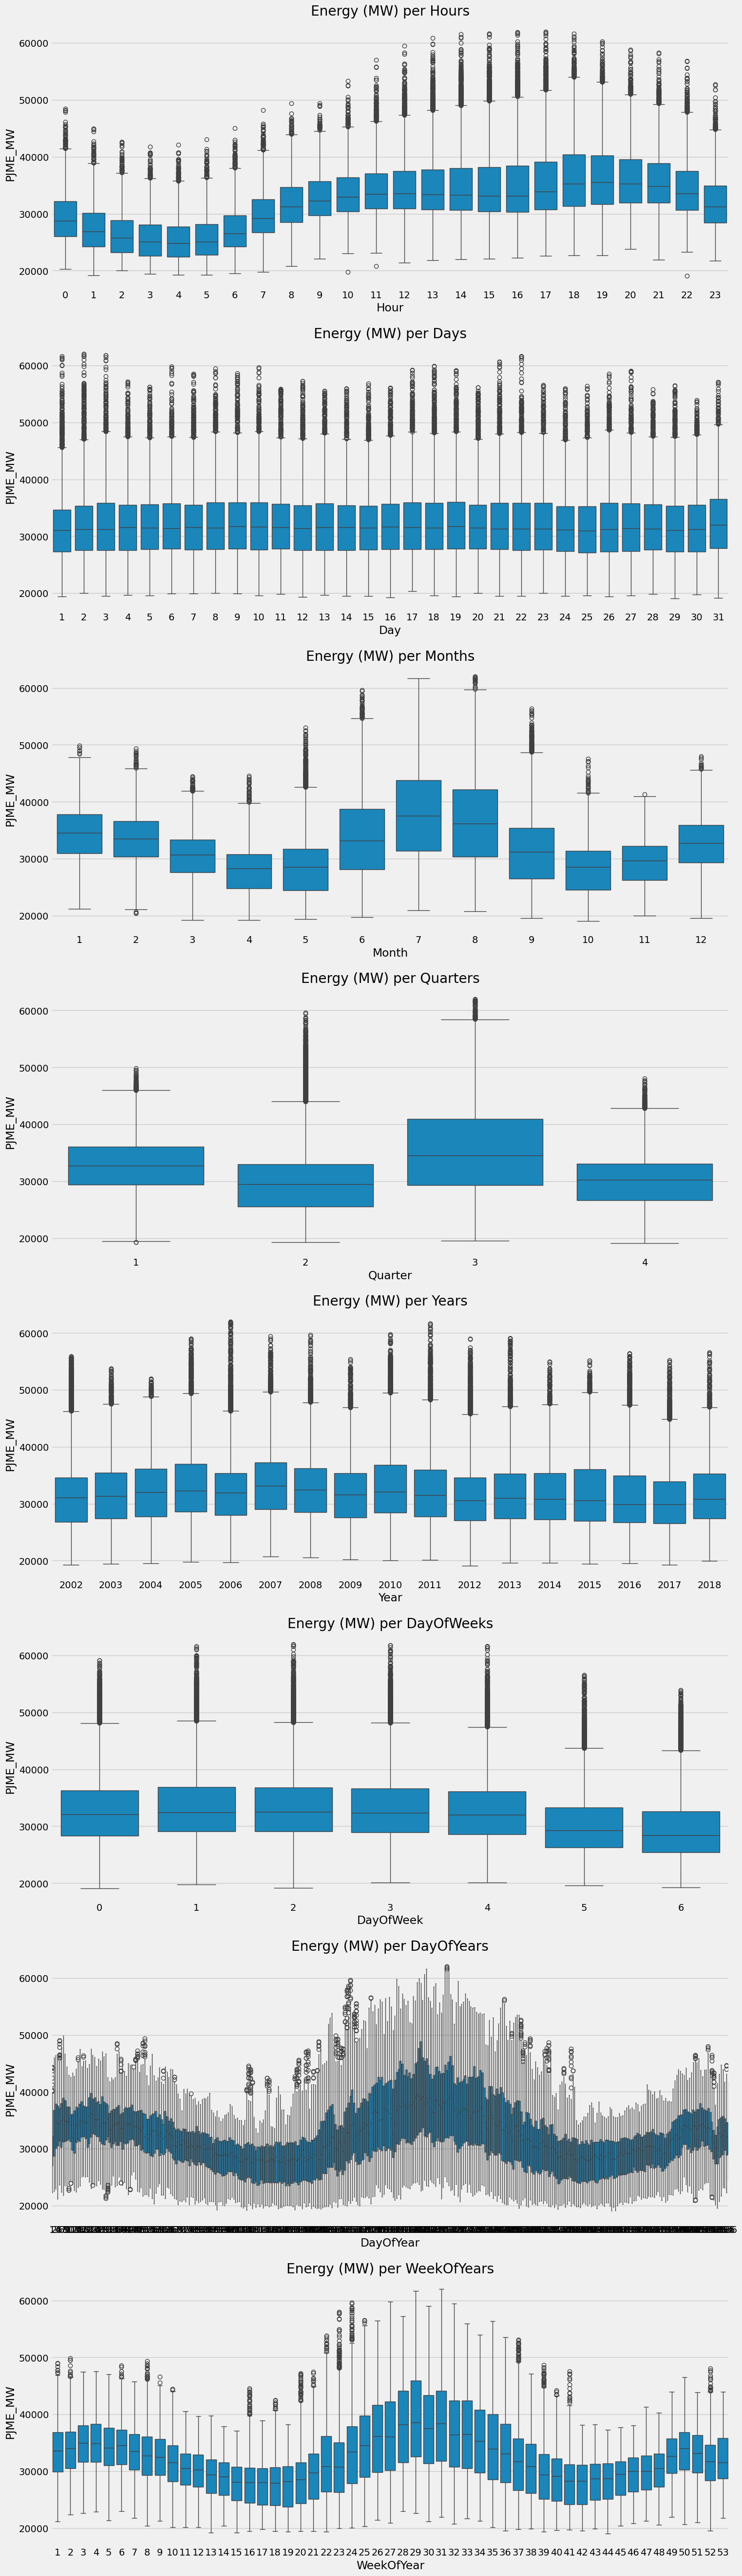

In [158]:
columns = ['Hour', 'Day', 'Month', 'Quarter', 'Year', 'DayOfWeek', 'DayOfYear', 'WeekOfYear']
fig, axs = plt.subplots(len(columns), 1 ,figsize=(16, len(columns) * 8))
for index, column in enumerate(columns):
    sns.boxplot(data=df, x=column, y='PJME_MW', ax=axs[index])
    axs[index].set_title(f'Energy (MW) per {column}s')
    axs[index].set_xlabel(column)
plt.show()

## Step 9 : Create a model

In [159]:
# Define the scalers and the model once, which is more efficient
ss_scaler = StandardScaler()
mms_scaler = MinMaxScaler()

# Define features and target
FEATURES = ['Hour', 'Day', 'Month', 'Quarter', 'Year', 'DayOfWeek', 'DayOfYear', 'WeekOfYear', 'Lag1', 'Lag2', 'Lag3']
TARGET = 'PJME_MW'

# Define XGBRegressor
xgb_reg = XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50,
    max_depth=3,
    learning_rate=0.01 # Corrected parameter name from 'earning_rate' to 'learning_rate'
)

# Initialize lists for predictions and scores
predictions = []
scores = []
fold = 0
for train_idx, val_idx in tss.split(energy_df):
    # Logging the Fold for debugging
    print(f'>>>> Fold : {fold + 1}')
    
    train = energy_df.iloc[train_idx] # Ensure you are using 'energy_df'
    test = energy_df.iloc[val_idx]
    
    # Feature creation and lagging should be done in separate functions
    train = create_features(train)
    test = create_features(test)

    train = create_lags(train)
    test = create_lags(test)

    X_train = train[FEATURES].to_numpy()
    X_test = test[FEATURES].to_numpy()

    # Fit and transform the scaler only on training data, then transform the test data
    X_train_scaled = ss_scaler.fit_transform(X_train)
    X_test_scaled = ss_scaler.transform(X_test)

    y_train = train[TARGET].to_numpy().reshape(-1, 1)
    y_test = test[TARGET].to_numpy().reshape(-1, 1)

    # Fit and transform the target scaler on training data only
    y_train_scaled = mms_scaler.fit_transform(y_train)
    y_test_scaled = mms_scaler.transform(y_test)

    # Train the model
    xgb_reg.fit(
        X_train_scaled,
        y_train_scaled,
        eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)],
        verbose=100
    )
    
    # Make predictions
    y_train_pred = xgb_reg.predict(X_train_scaled)
    y_train_pred_inverse = mms_scaler.inverse_transform(y_train_pred.reshape(-1, 1))
    y_test_pred = xgb_reg.predict(X_test_scaled)
    y_test_pred_inverse = mms_scaler.inverse_transform(y_test_pred.reshape(-1, 1))

    # Store predictions and scores
    predictions.append({
        'Predicted Train Energy (MW)': y_train_pred_inverse.flatten(),
        'Predicted Test  Energy (MW)': y_test_pred_inverse.flatten(),
                        })
    scores.append({
        'Train R2 score': r2_score(y_train, y_train_pred_inverse),
        'Test  R2 score': r2_score(y_test, y_test_pred_inverse),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_inverse)),
        'Test  RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_inverse)),
    })
    
    fold += 1

# Create DataFrames for predictions and scores
predictions_df = pd.DataFrame(predictions)
scores_df = pd.DataFrame(scores)

>>>> Fold : 1
[0]	validation_0-rmse:0.15043	validation_1-rmse:0.14378
[100]	validation_0-rmse:0.10175	validation_1-rmse:0.12750
[200]	validation_0-rmse:0.08878	validation_1-rmse:0.12173
[300]	validation_0-rmse:0.08237	validation_1-rmse:0.11020
[400]	validation_0-rmse:0.07888	validation_1-rmse:0.10456
[500]	validation_0-rmse:0.07706	validation_1-rmse:0.10080
[600]	validation_0-rmse:0.07589	validation_1-rmse:0.09874
[700]	validation_0-rmse:0.07497	validation_1-rmse:0.09729
[800]	validation_0-rmse:0.07418	validation_1-rmse:0.09635
[900]	validation_0-rmse:0.07340	validation_1-rmse:0.09596
[999]	validation_0-rmse:0.07273	validation_1-rmse:0.09571
>>>> Fold : 2
[0]	validation_0-rmse:0.14986	validation_1-rmse:0.14629
[100]	validation_0-rmse:0.10182	validation_1-rmse:0.13192
[200]	validation_0-rmse:0.08931	validation_1-rmse:0.12636
[300]	validation_0-rmse:0.08326	validation_1-rmse:0.11539
[400]	validation_0-rmse:0.07992	validation_1-rmse:0.10915
[500]	validation_0-rmse:0.07793	validation_1-rms

In [160]:
print(f'>>>> Time Series Training/Testing Energy Consumption Prediction using XGBoost Regressor : ')
print(f'> Train/Test R2 Score across folds: {np.mean(scores_df['Train R2 score']) * 100:0.2f}%, {np.mean(scores_df['Test  R2 score']) * 100:0.2f}%')
print(f'> Train/Test RMSE     across folds: {np.mean(scores_df['Train RMSE']):0.4f}, {np.mean(scores_df['Test  RMSE']):0.4f}')
print('> Folds across :')
scores_df

>>>> Time Series Training/Testing Energy Consumption Prediction using XGBoost Regressor : 
> Train/Test R2 Score across folds: 75.11%, 51.69%
> Train/Test RMSE     across folds: 3229.3689, 4367.4130
> Folds across :


Train R2 score  Test  R2 score   Train RMSE   Test  RMSE
0        0.768971        0.552341  3121.871680  4108.176933
1        0.734084        0.453976  3336.547487  4632.529449
2        0.756046        0.595003  3188.557232  4108.115999
3        0.755895        0.550631  3196.170802  4424.111376
4        0.740326        0.432322  3303.697366  4564.131410

## Step 10 : Predict the future data

[0]	validation_0-rmse:0.24602
[100]	validation_0-rmse:0.12474
[200]	validation_0-rmse:0.09387
[300]	validation_0-rmse:0.08559
[400]	validation_0-rmse:0.08216
[499]	validation_0-rmse:0.08034


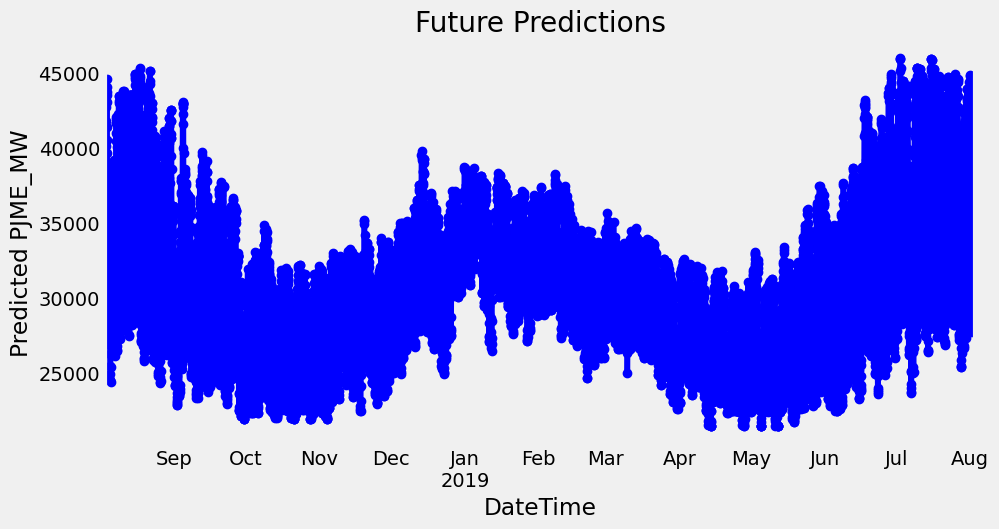

In [161]:
# Create features and lags
df = create_features(energy_df)
df = create_lags(df)

# Define features and target
FEATURES = ['Hour', 'Day', 'Month', 'Quarter', 'Year', 'DayOfWeek', 'DayOfYear', 'WeekOfYear', 'Lag1', 'Lag2', 'Lag3']
TARGET = 'PJME_MW'

# Initialize scalers
ss_scaler = StandardScaler()
mms_scaler = MinMaxScaler()

# Define the XGBRegressor
xgb_reg = XGBRegressor(
    base_score=0.5,
    booster='gbtree', 
    n_estimators=500,
    objective='reg:squarederror',  # Use 'reg:squarederror' as 'reg:linear' is deprecated
    max_depth=3,
    learning_rate=0.01
)

# Prepare data
X_all = df[FEATURES].to_numpy()
X_all_scaled = ss_scaler.fit_transform(X_all)  # Scale features
    
y_all = df[TARGET].to_numpy().reshape(-1, 1)
y_all_scaled = mms_scaler.fit_transform(y_all)  # Scale target

# Train the model on scaled data
xgb_reg.fit(
    X_all_scaled, y_all_scaled,
    eval_set=[(X_all_scaled, y_all_scaled)],
    verbose=100
)

# Create future dates for predictions
last_date = df.index.max()
last_future_date = last_date + pd.DateOffset(years=1)
future_index = pd.date_range(last_date, last_future_date, freq='1h')

# Create a DataFrame for future predictions
future_df = pd.DataFrame(index=future_index)
future_df['isFuture'] = True

# Mark the original DataFrame as not future
df['isFuture'] = False

# Combine past and future data
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = create_lags(df_and_future)

# Select future features
future_w_features = df_and_future[df_and_future['isFuture']].copy()
X_future = future_w_features[FEATURES].to_numpy()
X_future_scaled = ss_scaler.transform(X_future)  # Scale future features

# Make predictions
y_future_scaled = xgb_reg.predict(X_future_scaled)
future_w_features['Predicted_PJME_MW'] = mms_scaler.inverse_transform(y_future_scaled.reshape(-1, 1))

# Plot the future predictions
plt.figure(figsize=(10, 5))
future_w_features['Predicted_PJME_MW'].plot(color='blue', marker='o', linestyle='-', title='Future Predictions')
plt.xlabel('DateTime')
plt.ylabel('Predicted PJME_MW')
plt.grid()
plt.show()

## Step 11 : Importance Features 

<Figure size 1000x600 with 0 Axes>

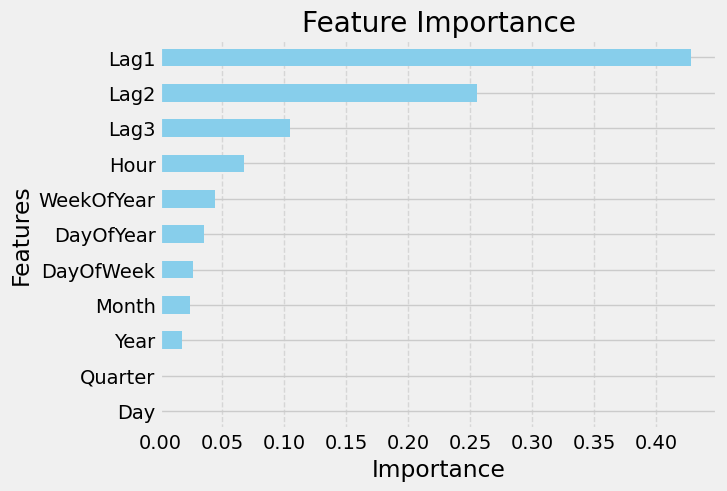

In [162]:
# Extract feature importances and create a DataFrame
features_df = pd.DataFrame({
    'importance': xgb_reg.feature_importances_
}, index=FEATURES)

# Sort the DataFrame by importance
features_df_sorted = features_df.sort_values(by='importance')

# Plotting the feature importance
plt.figure(figsize=(10, 6))  # Set a figure size for better visibility
features_df_sorted.plot(kind='barh', legend=False, title='Feature Importance', color='skyblue')

# Adding labels and grid for better readability
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Step 12 : Save the model

In [163]:
model_dir = r'f:/Python_Projects/AppliedMechineLearningWithPython/Project_10_Energy_Consumption_Prediction/models'
# model_dir = '/content/drive/My Drive/Applied Machine Learning/Project 10 : Energy Consumption Prediction/models'
# model_dir = '/kaggle/working'

# Saving the xgboost model
model_path = os.path.join(model_dir, 'xgb_reg_model.bin')
xgb_reg.save_model(model_path)
print(f'> The XGBRegressor model saved to {model_path}')

> The XGBRegressor model saved to f:/Python_Projects/AppliedMechineLearningWithPython/Project_10_Energy_Consumption_Prediction/models\xgb_reg_model.bin
